# Model Comparison
## This notebook compares the performance of the basis paper and the proposal on a random generated track of 100 rounds

In [1]:
import os
import gym
import gym_donkeycar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import time
import pickle
import birds_eye_vector_space
import basis_my_cv
import random
from pandas import Series, DataFrame
from collections import deque
from scipy.stats import ttest_ind

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
#from keras import backend as K
#import tensorflow.keras.backend as K

C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\studwilksa2535\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find d

In [2]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# EDA - Look into the collected data

In [3]:
vector_path = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\1505model\\raw_data\\data-episode-5000.pkl'

In [4]:
basis_path = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\2305basis\\raw_data\\data-episode-5000.pkl'

## Vector space data

In [5]:
vector_data = pd.read_pickle(vector_path)
vector_data.head()

,reward,loss,time,max_cte,average_cte,lap_time
episode,,,,,,
1,7.640503,1.046192,26.258771,5.073248,-0.380517,0
2,4.108565,1.289525,16.698219,0.041872,-1.235362,0
3,3.142123,2.104326,17.722085,0.000222,-1.325995,0
4,3.895656,2.245471,17.472533,0.036836,-1.175621,0
5,-0.404008,3.362091,25.593469,5.043936,-1.497711,0


In [6]:
vector_data.describe().T

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1558: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


,count,mean,std,min,25%,50%,75%,max
reward,5000.0,5.776567,5.484665,-13.691257,2.099768,5.892893,9.963732,18.018433
loss,5000.0,68.409776,90.868805,1.046192,25.823920,30.328751,41.304948,638.141406
time,5000.0,49.044662,36.172481,13.591713,22.256927,31.704545,66.532217,130.105677
max_cte,5000.0,3.213012,1.996148,0.000148,1.260071,3.654488,5.076596,6.861388
average_cte,5000.0,-0.217315,1.093597,-3.631743,-1.064863,-0.069685,0.515278,2.970050
lap_time,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
#t = 'C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\vector_loss.png'

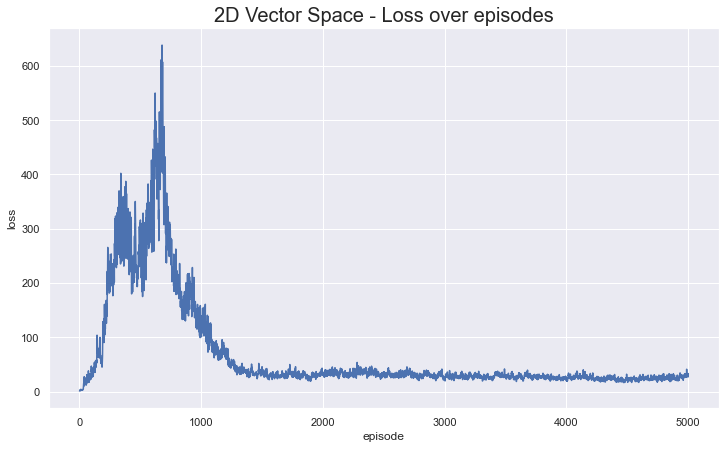

In [8]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=vector_data.index, y=vector_data['loss'])
plt.title('2D Vector Space - Loss over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\vector_loss.png')
plt.show()

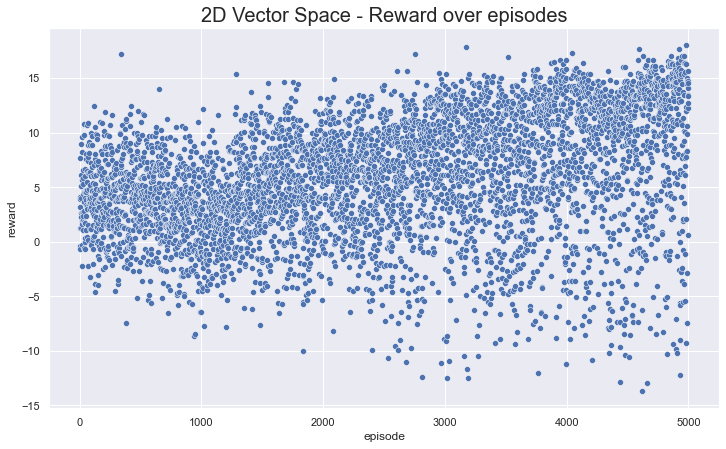

In [9]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=vector_data.index, y=vector_data['reward'])
plt.title('2D Vector Space - Reward over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\vector_reward.png')
plt.show()

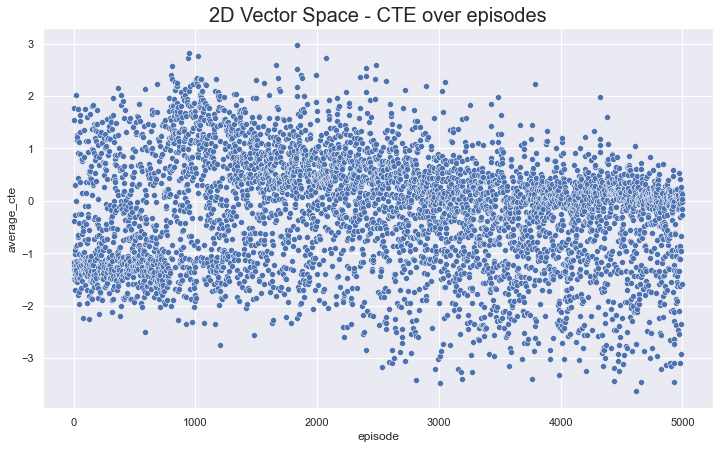

In [10]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=vector_data.index, y=vector_data['average_cte'])
plt.title('2D Vector Space - CTE over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\vector_cte.png')
plt.show()

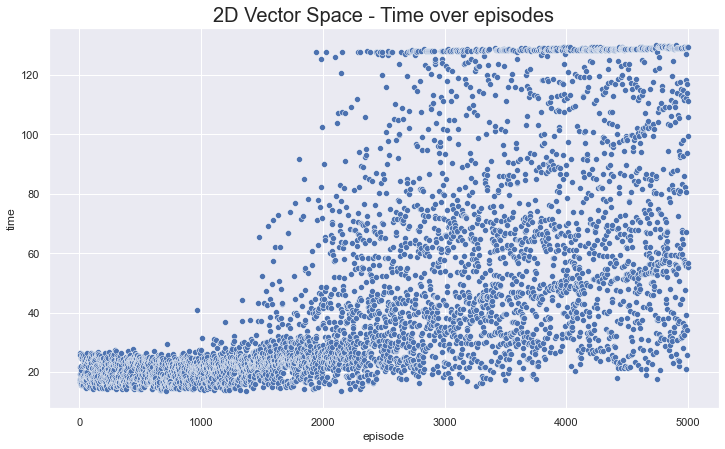

In [11]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=vector_data.index, y=vector_data['time'])
plt.title('2D Vector Space - Time over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\vector_time.png')
plt.show()

In [12]:
# Normalizing the loss feature/column
test = (vector_data['loss'] - vector_data['loss'].min()) / (vector_data['loss'].max() - vector_data['loss'].min())

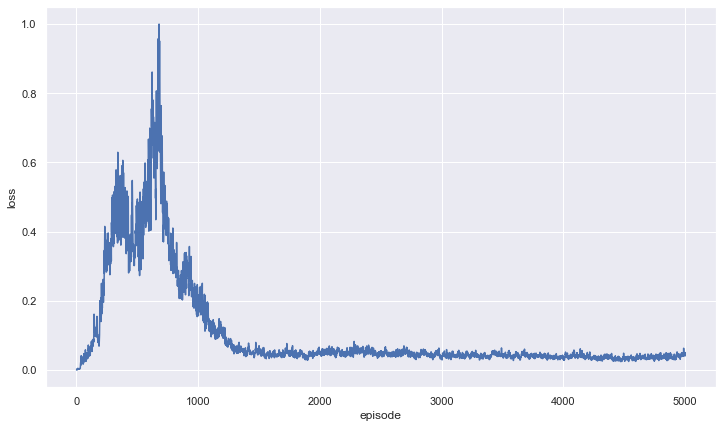

In [13]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=vector_data.index, y=test)
plt.show()

In [14]:
# Mean of the reward
print('Reward: %s' % vector_data['reward'].mean())
print('Time: %s' % vector_data['time'].mean())
print('CTE: %s' % vector_data['average_cte'].mean())

Reward: 5.776567390840364
Time: 49.044661979341505
CTE: -0.21731474539515297


## Basis data

In [15]:
basis_data = pd.read_pickle(basis_path)
basis_data.head()

,reward,loss,time,max_cte,average_cte,lap_time
episode,,,,,,
1,3.762015,2.093281,23.364872,5.079184,1.165557,0
2,7.892035,2.459800,18.844890,5.072938,0.941375,0
3,10.300389,2.558895,21.813035,5.011147,0.459340,0
4,1.688151,2.722199,20.884716,5.028355,1.525892,0
5,0.378518,2.570670,16.729365,5.079382,1.786951,0


In [16]:
basis_data.describe().T

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1558: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


,count,mean,std,min,25%,50%,75%,max
reward,5000.0,5.947361,6.023606,-14.789154,2.125447,5.760486,9.557940,21.870955
loss,5000.0,37.967503,24.936346,1.568558,22.396756,29.595672,45.341097,219.922466
time,5000.0,62.965709,44.763304,13.634162,23.530769,42.042922,128.359573,129.995088
max_cte,5000.0,2.745350,1.852643,0.000000,0.992692,2.627742,5.007470,11.784060
average_cte,5000.0,-0.200898,1.107545,-3.767913,-0.943158,-0.078214,0.616099,2.803082
lap_time,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


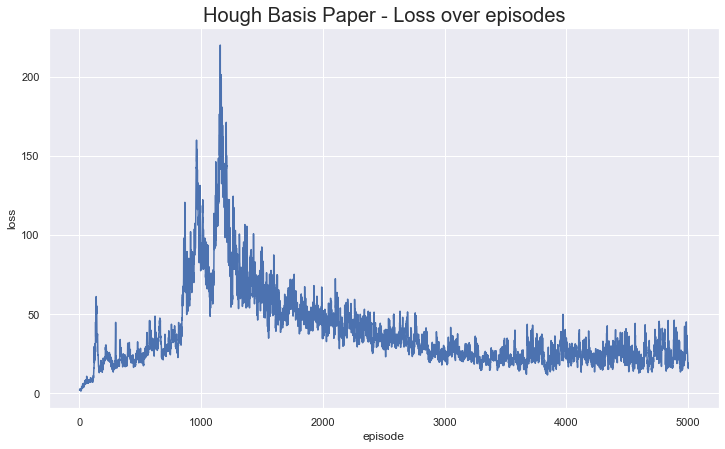

In [17]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=basis_data.index, y=basis_data['loss'])
plt.title('Hough Basis Paper - Loss over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\basis_loss.png')
plt.show()

In [18]:
# Normalizing the loss feature/column
test2 = (basis_data['loss'] - basis_data['loss'].min()) / (basis_data['loss'].max() - basis_data['loss'].min())

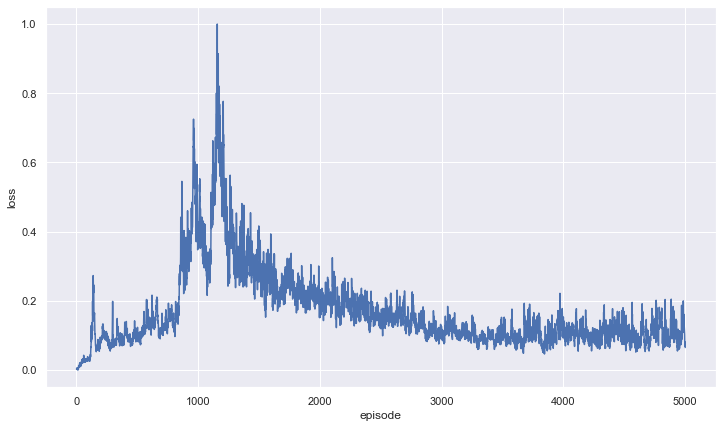

In [19]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=basis_data.index, y=test2)
plt.show()

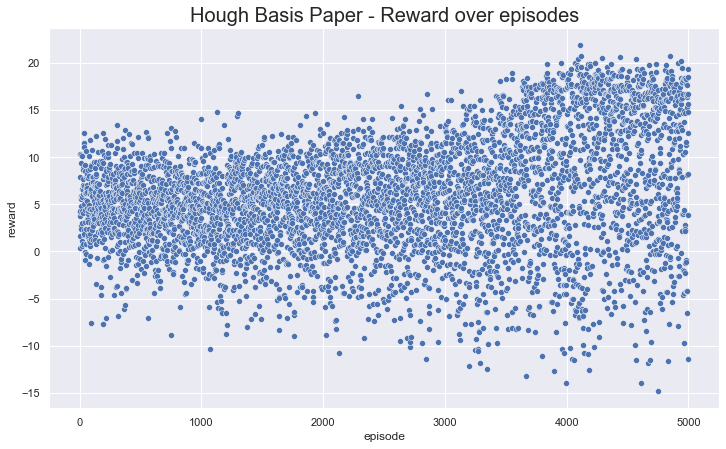

In [20]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=basis_data.index, y=basis_data['reward'])
plt.title('Hough Basis Paper - Reward over episodes', fontsize=20)
#plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\basis_reward.png')
plt.show()

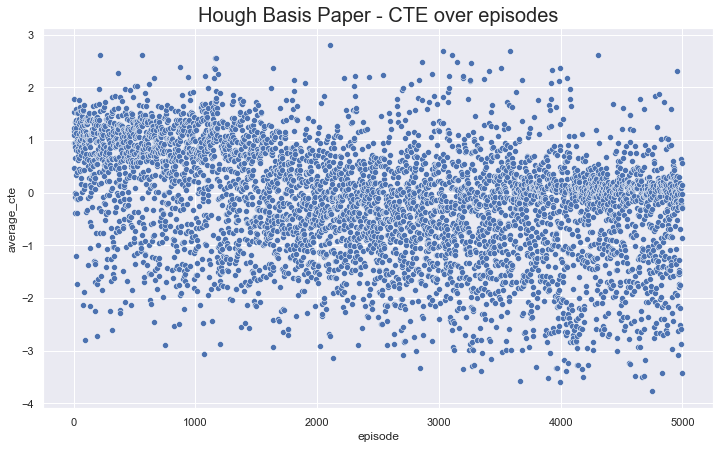

In [21]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=basis_data.index, y=basis_data['average_cte'])
plt.title('Hough Basis Paper - CTE over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\basis_cte.png')
plt.show()

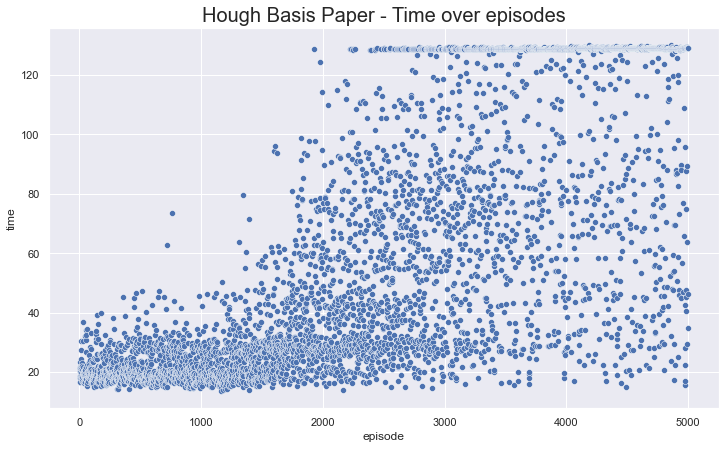

In [22]:
plt.figure(figsize=(12,7))
_ = sns.scatterplot(x=basis_data.index, y=basis_data['time'])
plt.title('Hough Basis Paper - Time over episodes', fontsize=20)
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\basis_time.png')
plt.show()

# Comparing both model loss

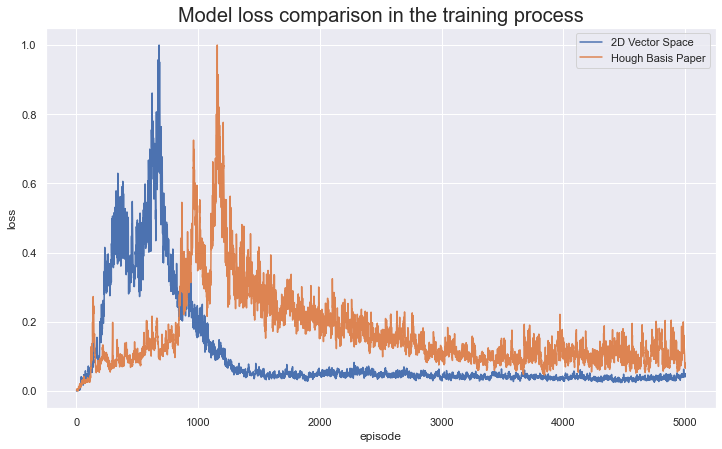

In [23]:
plt.figure(figsize=(12,7))
plt.title('Model loss comparison in the training process', fontsize=20)
_ = sns.lineplot(x=basis_data.index, y=test)
_ = sns.lineplot(x=basis_data.index, y=test2)
plt.legend(labels=['2D Vector Space','Hough Basis Paper'], loc='upper right')
plt.savefig('C:\\Users\\studwilksa2535\\Desktop\\DonkeyCarAI\\training_plots\\model_compared.png')
plt.show()

# Comparing other features

In [24]:
# Normalize
basis_data['reward'] = (basis_data['reward'] - basis_data['reward'].min()) / (basis_data['reward'].max() - basis_data['reward'].min())
basis_data['average_cte'] = (basis_data['average_cte'] - basis_data['average_cte'].min()) / (basis_data['average_cte'].max() - basis_data['average_cte'].min())
basis_data['time'] = (basis_data['time'] - basis_data['time'].min()) / (basis_data['time'].max() - basis_data['time'].min())

In [25]:
# Normalize
vector_data['reward'] = (vector_data['reward'] - vector_data['reward'].min()) / (vector_data['reward'].max() - vector_data['reward'].min())
vector_data['average_cte'] = (vector_data['average_cte'] - vector_data['average_cte'].min()) / (vector_data['average_cte'].max() - vector_data['average_cte'].min())
vector_data['time'] = (vector_data['time'] - vector_data['time'].min()) / (vector_data['time'].max() - vector_data['time'].min())

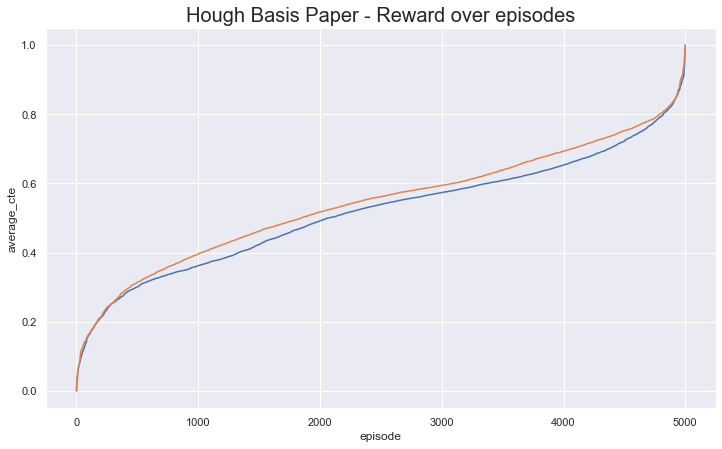

In [26]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=basis_data.index, y=vector_data['average_cte'].sort_values())
_ = sns.lineplot(x=basis_data.index, y=basis_data['average_cte'].sort_values())
plt.title('Hough Basis Paper - Reward over episodes', fontsize=20)
plt.show()

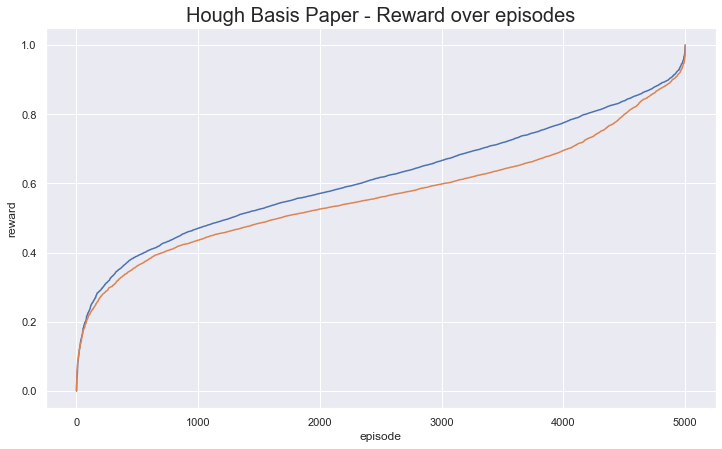

In [27]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=basis_data.index, y=vector_data['reward'].sort_values())
_ = sns.lineplot(x=basis_data.index, y=basis_data['reward'].sort_values())
plt.title('Hough Basis Paper - Reward over episodes', fontsize=20)
plt.show()

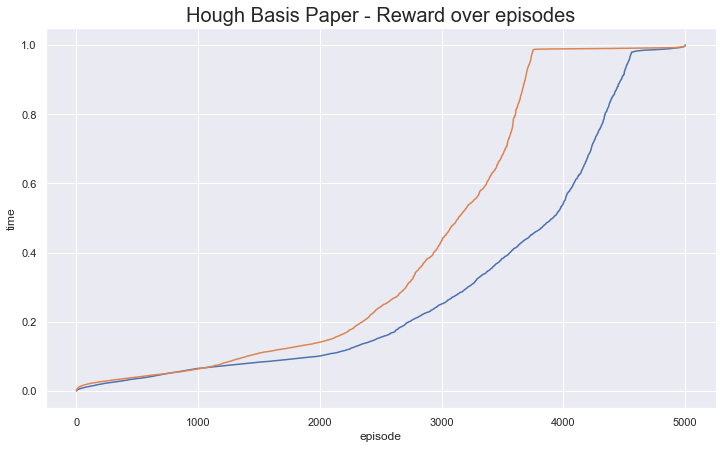

In [28]:
plt.figure(figsize=(12,7))
_ = sns.lineplot(x=basis_data.index, y=vector_data['time'].sort_values())
_ = sns.lineplot(x=basis_data.index, y=basis_data['time'].sort_values())
plt.title('Hough Basis Paper - Reward over episodes', fontsize=20)
plt.show()